## Part 1 : Data loading and preprocessing

In [55]:
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import iqr
import glob
import os

import warnings 
warnings.filterwarnings('ignore')

In [56]:
arts_pre  = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "dataset/Articles*.csv"))))
comms_pre = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "dataset/Comments*.csv"))))

#remove features that i don't need
comms_pre.drop(['printPage','parentUserDisplayName','picURL','recommendedFlag','userID',
            'permID','userTitle','userDisplayName','userURL','userLocation',
            'reportAbuseFlag', 'status','inReplyTo','commentSequence','commentTitle',
            'commentType', 'approveDate', 'createDate','updateDate','parentID'],
           axis=1,inplace=True)

arts_pre.drop(['abstract', 'documentType','multimedia', 'printPage',
           'pubDate','snippet','source','webURL', 'articleWordCount', 'keywords'],
          axis=1,inplace=True)

In [57]:
print(comms_pre.shape) # ~2e6 comments with 34 features each
print(arts_pre.shape) #9300 comments with 15 features each

(2176364, 14)
(9335, 6)


#### Data preprocessing

In [58]:
#remove bad characters such as & and <br/>
def preprocess(commentBody):
    commentBody = commentBody.str.replace("(<br/>)", "")
    commentBody = commentBody.str.replace('(<a).*(>).*(</a>)', '')
    commentBody = commentBody.str.replace('(&amp)', '')
    commentBody = commentBody.str.replace('(&gt)', '')
    commentBody = commentBody.str.replace('(&lt)', '')
    commentBody = commentBody.str.replace('(\xa0)', ' ')  
    return commentBody

comms_pre.commentBody = preprocess(comms_pre.commentBody)

In [59]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Stemmer = PorterStemmer()
stops = set(stopwords.words("english"))

In [60]:
def cleanList(myList):
    cleanedList = []
    for i,el in enumerate(myList):
        cleanedList.append(cleanText(el))
        print(str(i),end='\r')
    return cleanedList


def cleanText(rawText):

    nice_words   = [Stemmer.stem(word) for word in word_tokenize(rawText.lower()) if word.isalpha() and word not in stopwords.words("english")]
    joined_words = ( " ".join(nice_words))

    return joined_words

##### <span style="color:red"> If you already have All_Comments_clean.csv, do not run the following cell (very slow) </span>

In [61]:
#full_comms = list(comms_pre['commentBody'])

#clean_comm_bodies = cleanList(full_comms)

##Add cleaned data back into DataFrame
#comms_pre['commentBody'] = clean_comm_bodies
#comms_pre.to_csv("dataset/All_Comments_clean.csv",header=True)

In [10]:
#arts_pre.to_csv("dataset/All_Articles_clean.csv",header=True)

##### Run only this one if you already have the cleaned files

In [11]:
arts = pd.read_csv("dataset/All_Articles_clean.csv")
comms = pd.read_csv("dataset/All_Comments_clean.csv")

In [12]:
comms = comms[comms.commentBody.notnull()]
comms.drop(['Unnamed: 0'], axis=1, inplace=True)
arts.drop(['Unnamed: 0'], axis=1, inplace=True)
arts.drop_duplicates(subset='articleID',keep='first')
comms = comms.drop_duplicates(subset='commentID',keep='first')

In [13]:
UnkHead = arts[ arts['headline'] == 'Unknown' ].index
arts.drop(UnkHead,inplace=True)

In [14]:
arts.headline.nunique()
# hints for hot topics
# beware! Different number of articles/comments
# keep track of this (maybe weigh on total number)
print(arts.shape)

(8603, 6)


## Part 2

### Assigning a score to each comment (AFINN-111 lexicon)

In [15]:
from afinn import Afinn
afinn = Afinn(language='en')

In [16]:
def comment_score (comment):
    commList = comment.split()
    tempScore = 0
    for word in commList:
        tempScore += afinn.score_with_wordlist(word)
    tempScore /= math.sqrt(len(commList)+1)
    return tempScore

In [17]:
#this takes some time (~1 min)
comms['commentScore'] = comms['commentBody'].apply(comment_score)
comms['commentScore'] = comms['commentScore'] + comms['recommendations'] / comms['recommendations'].max()

<AxesSubplot:>

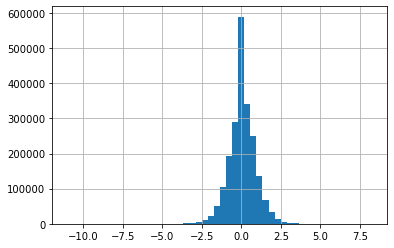

In [18]:
comms['commentScore'].hist(bins=50)

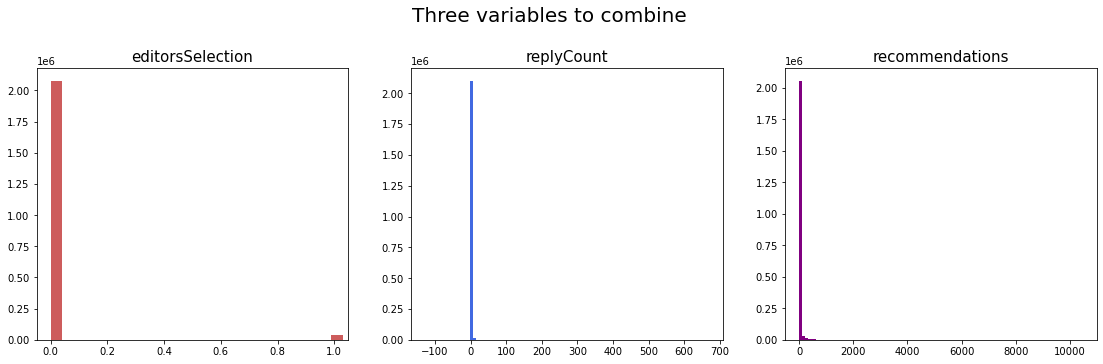

editorsSelection:  0  -  1
replyCount:  -128.0  -  668.0
recommendations:  0.0  -  10472.0


In [19]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle('Three variables to combine', fontsize=20, y=1.05)

axs[0].hist(comms['editorsSelection'],bins=100, color='indianred', width=0.04)
axs[0].set_title('editorsSelection', fontsize=15)
axs[1].hist(comms['replyCount'],bins=100, color='royalblue')
axs[1].set_title('replyCount', fontsize=15)
#axs[1].set_xlim(0,670)
axs[2].hist(comms['recommendations'],bins=100, color='purple')
axs[2].set_title('recommendations', fontsize=15)
#axs[2].set_xlim(0,10000)

plt.show()


print("editorsSelection: ", comms['editorsSelection'].min(), " - ", comms['editorsSelection'].max())
print("replyCount: ", comms['replyCount'].min(),  " - ", comms['replyCount'].max())
print("recommendations: ", comms['recommendations'].min(), " - ", comms['recommendations'].max())

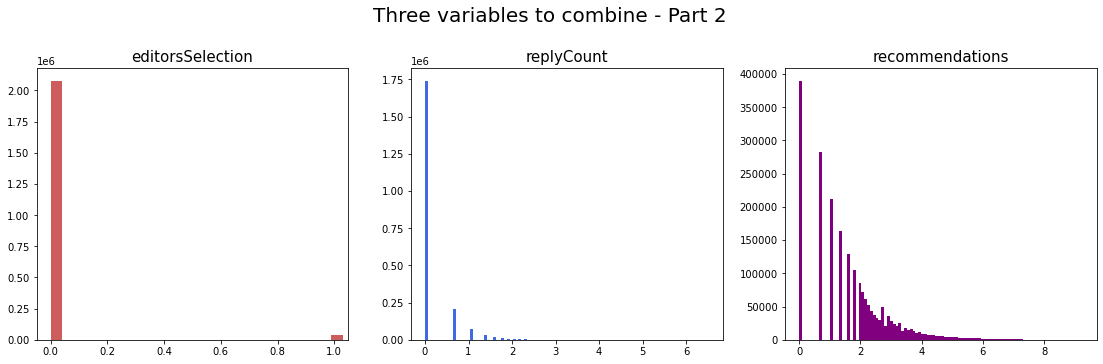

editorsSelection:  0  -  1
replyCount:  -128.0  -  668.0
recommendations:  0.0  -  10472.0


In [20]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle('Three variables to combine - Part 2', fontsize=20, y=1.05)

axs[0].hist(comms['editorsSelection'],bins=100, color='indianred', width=0.04)
axs[0].set_title('editorsSelection', fontsize=15)
axs[1].hist(np.log(1 +comms['replyCount']),bins=100, color='royalblue')
axs[1].set_title('replyCount', fontsize=15)
#axs[1].set_xlim(0,670)
axs[2].hist(np.log(1 +comms['recommendations']),bins=100, color='purple')
axs[2].set_title('recommendations', fontsize=15)
#axs[2].set_xlim(0,10000)

plt.show()


print("editorsSelection: ", comms['editorsSelection'].min(), " - ", comms['editorsSelection'].max())
print("replyCount: ", comms['replyCount'].min(),  " - ", comms['replyCount'].max())
print("recommendations: ", comms['recommendations'].min(), " - ", comms['recommendations'].max())

In [21]:
#comms['success'] =(1 + comms['editorsSelection']) * np.log(1.05 + comms['replyCount']) * np.log(1.05 + comms['recommendations'])
#comms['success'] = (1 + comms['editorsSelection']) * (1 +comms['replyCount']) * (1 + comms['recommendations'])
#comms['success'] = (1 + comms['editorsSelection']) * ( comms['replyCount'] + comms['recommendations'])
#comms['success'] = (comms['success'] - comms['success'].mean()) / comms['success'].std()
#plt.hist((comms['success']), bins=250, color='orange')
#plt.grid(alpha=0.4)
#plt.xlim(-5,5)
#plt.show()
#comms['success'].describe()

#talk about many trials i did here

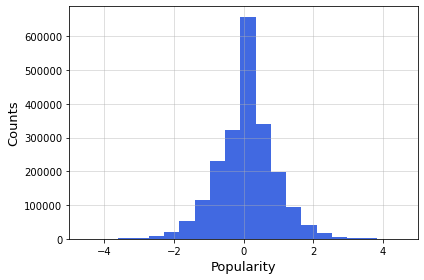

In [36]:
#comms['popularity'] = comms['commentScore']
comms['popularity'] = (1 + comms['editorsSelection']) * comms['commentScore']
fig = plt.hist(comms['popularity'],bins=70, color='royalblue')
plt.grid(alpha=0.5)
plt.xlim(-5,5)
plt.xlabel("Popularity",fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.tight_layout()
#plt.show()
plt.savefig("Pictures/PopularityDist.pdf")
#comms['popularity'].describe()

In [35]:
help(plt.savefig)

Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, dpi=None, facecolor='w', edgecolor='w',
              orientation='portrait', papertype=None, format=None,
              transparent=False, bbox_inches=None, pad_inches=0.1,
              frameon=None, metadata=None)
    
    The available output formats depend on the backend being used.
    
    Parameters
    ----------
    fname : str or path-like or file-like
        A path, or a Python file-like object, or
        possibly some backend-dependent object such as
        `matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is set, it determines the output format, and the file
        is saved as *fname*.  Note that *fname* is used verbatim, and there
        is no attempt to make the extension, if any, of *fname* match
        *format*, and no extension is appended.
    
        If *format* is not set, then th

<AxesSubplot:>

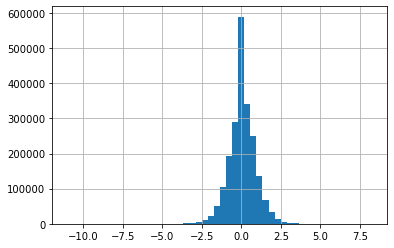

In [23]:
comms['commentScore'].hist(bins=50)

### Assign a score to each article

In [38]:
grouper = comms.groupby('articleID')
to_merge = grouper.sum().divide(np.sqrt(grouper.count()+1)).reset_index().rename(columns={'popularity': 'articleScore'})[['articleID', 'articleScore']]
arts = arts.merge(to_merge, on='articleID')

In [39]:
arts['articleScore'].describe()

count    8435.000000
mean        1.469193
std         3.769928
min       -24.232418
25%        -0.041518
50%         1.359365
75%         3.243744
max        53.917854
Name: articleScore, dtype: float64

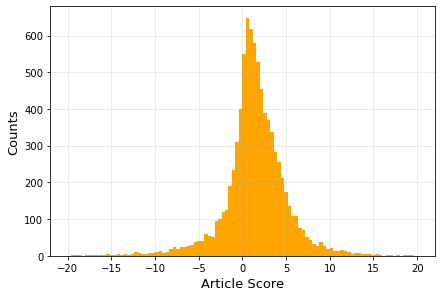

In [41]:
plt.hist(arts['articleScore'], bins=100, range=(-20,20), color='orange')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.xlabel("Article Score", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.savefig("Pictures/articleScoreDistriibution.pdf")
# polarity distribution of the articles

## Part 3 : Defining controversy (popularity + debate)

In [27]:
arts_old = arts.copy(deep=False)

#### Strategy 1 : Popularity x debate

##### Popularity = Total number of comments under each article (normalized to be 0-100)

In [47]:
arts['commentNumber'] = arts['articleID'].map(comms['articleID'].value_counts())
arts['commentNumber'] = 100 * arts['commentNumber'] / arts['commentNumber'].max()

In [48]:
arts.sort_values(by='commentNumber',ascending=False, inplace=True)

##### Debate: interquartile range of the comment scores in an article (normalized to 0-1)

In [49]:
arts['debate'] = arts['articleID'].map(comms.groupby('articleID')['popularity'].agg(iqr))
arts['debate'] = arts['debate'] / arts['debate'].max()

In [50]:
# Now finally controversiality

In [51]:
arts['controv'] =  arts['commentNumber'] * (0.001 + arts['debate'])
arts.sort_values(by='controv',ascending=False,inplace=True)
# Remember all trials!! (Without normalization, without epsilon, ...)

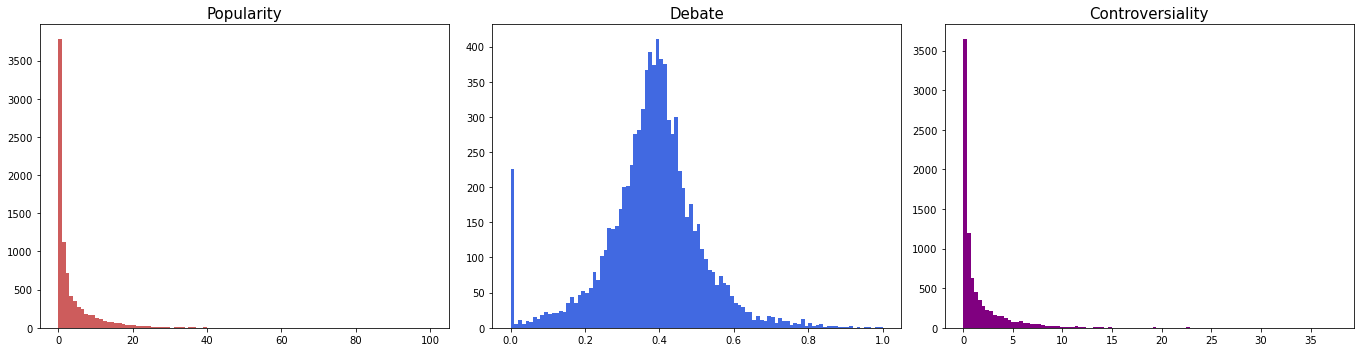

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
#fig.suptitle('Distributions - Strategy 1', fontsize=20)

axs[0].hist(arts['commentNumber'],bins=100, color='indianred')
axs[0].set_title('Popularity', fontsize=15)
axs[1].hist(arts['debate'],bins=100, color='royalblue')
axs[1].set_title('Debate', fontsize=15)
axs[2].hist(arts['controv'],bins=100, color='purple')
axs[2].set_title('Controversiality', fontsize=15)

plt.tight_layout()
plt.savefig("Pictures/Strat1Dist.pdf")

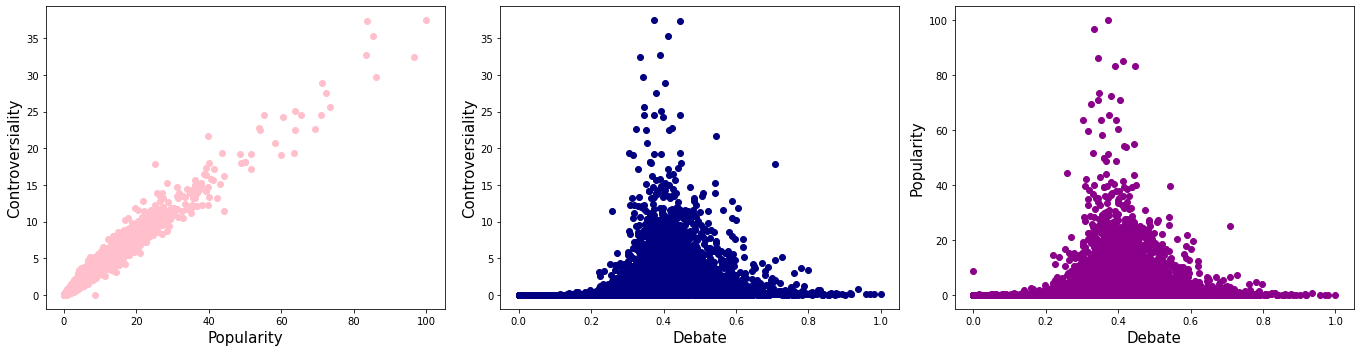

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
#fig.suptitle("Correlations - Strategy 1",fontsize=20)
axs[0].scatter(arts['commentNumber'],arts['controv'], color='pink')
axs[0].set_xlabel('Popularity', fontsize=15)
axs[0].set_ylabel('Controversiality', fontsize=15)
axs[1].scatter(arts['debate'], arts['controv'],color='navy')
axs[1].set_xlabel('Debate', fontsize=15)
axs[1].set_ylabel('Controversiality', fontsize=15)
axs[2].scatter( arts['debate'],arts['commentNumber'],color='darkmagenta')
axs[2].set_ylabel('Popularity', fontsize=15)
axs[2].set_xlabel('Debate', fontsize=15)

plt.tight_layout()
plt.savefig("Pictures/Strat1Corr.pdf")

#### Strategy 2: log(Popularity) * Debate

In [54]:
arts2 = arts_old.copy(deep=False)

NameError: name 'arts_old' is not defined

In [36]:
arts2['commentNumber'] = arts['articleID'].map(comms['articleID'].value_counts())
arts2['debate'] = arts['articleID'].map(comms.groupby('articleID')['popularity'].agg(iqr))
arts2['logCommentNumber'] = 1 + np.log10(arts2['commentNumber'])
arts2['controv'] = arts2['logCommentNumber'] * (0.01 + arts2['debate'])

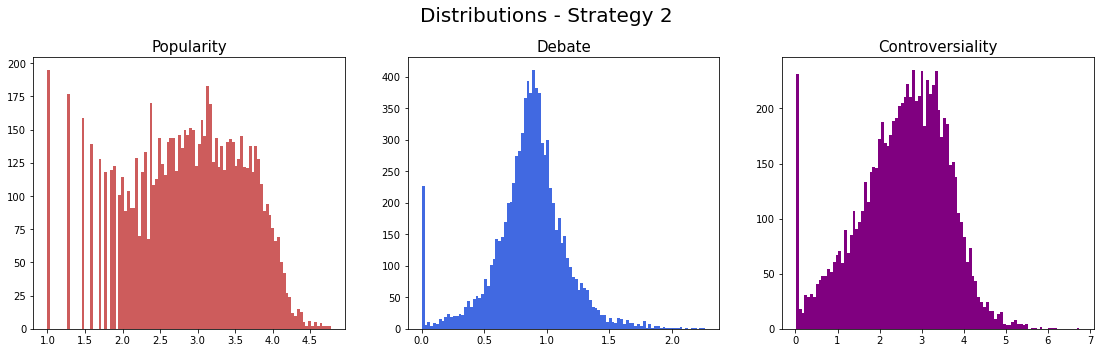

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle('Distributions - Strategy 2', fontsize=20, y=1.02)

axs[0].hist(arts2['logCommentNumber'],bins=100, color='indianred')
axs[0].set_title('Popularity', fontsize=15)
axs[1].hist(arts2['debate'],bins=100, color='royalblue')
axs[1].set_title('Debate', fontsize=15)
axs[2].hist(arts2['controv'],bins=100, color='purple')
axs[2].set_title('Controversiality', fontsize=15)

plt.show()

In [38]:
arts2.sort_values(by='controv',ascending=False,inplace=True)

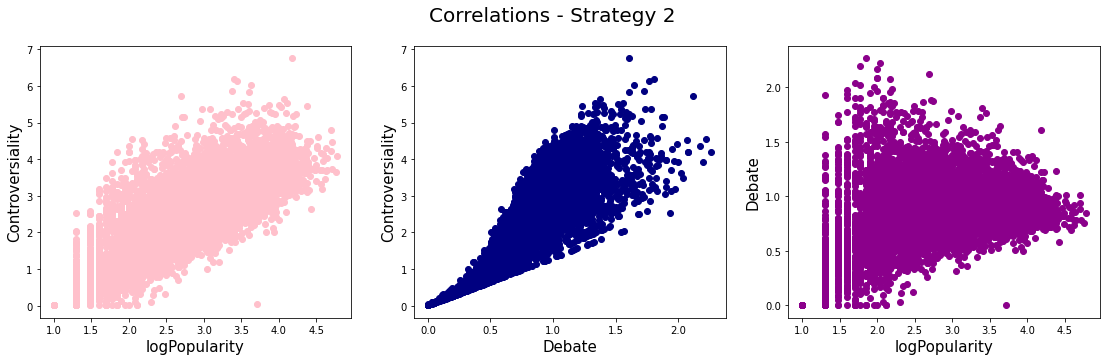

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
fig.suptitle('Correlations - Strategy 2', fontsize=20, y=0.99)

axs[0].scatter(arts2['logCommentNumber'],arts2['controv'],color='pink')
axs[0].set_xlabel('logPopularity', fontsize=15)
axs[0].set_ylabel('Controversiality', fontsize=15)
axs[1].scatter(arts2['debate'], arts2['controv'], color='navy')
axs[1].set_xlabel('Debate', fontsize=15)
axs[1].set_ylabel('Controversiality', fontsize=15)
axs[2].scatter(arts2['logCommentNumber'], arts2['debate'], color='darkmagenta')
axs[2].set_xlabel('logPopularity', fontsize=15)
axs[2].set_ylabel('Debate', fontsize=15)

fig.show()

In [40]:
#arts2.head(10)

In [41]:
#arts2.tail(10)

## Part 4: Grouping by category

### Section name - Strategy 1

In [42]:
dftot = pd.DataFrame()
dftot['sectionName'] = arts['sectionName'].unique()
dftot.sort_values(by='sectionName',inplace=True)
grouper = arts.groupby('sectionName').mean()['controv']
grouper2 = arts.groupby('sectionName').mean()['commentNumber']
dftot['SecControv'] = dftot['sectionName'].map(grouper)
dftot['Popularity']= dftot['sectionName'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

In [43]:
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

In [44]:
#fig, ax = plt.subplots(figsize=(5,25))
#ind = np.arange(len(dftot))
#wi = 0.4
#ax.barh(ind, dftot.SecControv, wi, color='green', label='Controverse')#
#ax.barh(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

#ax.set(yticks=ind + wi, yticklabels=dftot.sectionName, ylim=[2*wi - 1, len(dftot)])
#ax.legend()
#plt.show()

#ax.barh(ind, df.n, width, color='red', label='N')
#ax.barh(ind + width, df.m, width, color='green', label='M')

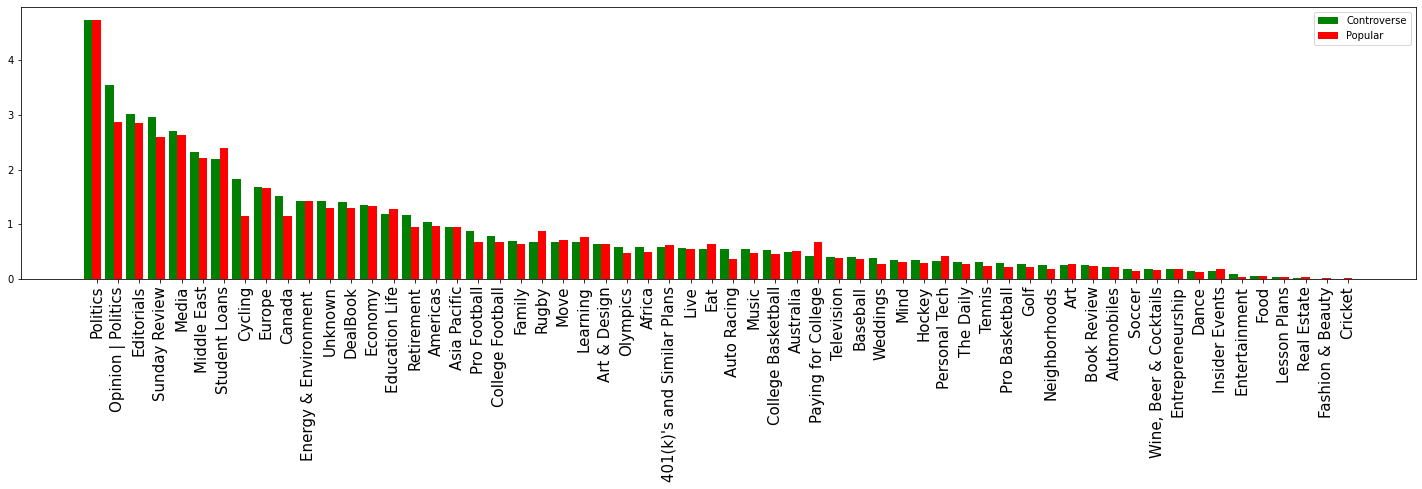

In [45]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.sectionName)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

### Section Name - Strategy 2

In [46]:
dftot = pd.DataFrame()
dftot['sectionName'] = arts['sectionName'].unique()
dftot.sort_values(by='sectionName',inplace=True)
grouper = arts2.groupby('sectionName').mean()['controv']
grouper2 = arts2.groupby('sectionName').mean()['commentNumber']
dftot['SecControv'] = dftot['sectionName'].map(grouper)
dftot['Popularity']= dftot['sectionName'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

In [47]:
#fig, ax = plt.subplots(figsize=(5,25))
#ind = np.arange(len(dftot))
#wi = 0.4
#ax.barh(ind, dftot.SecControv, wi, color='green', label='Controverse')
#ax.barh(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

#ax.set(yticks=ind + wi, yticklabels=dftot.sectionName, ylim=[2*wi - 1, len(dftot)])
#ax.legend()
#plt.show()

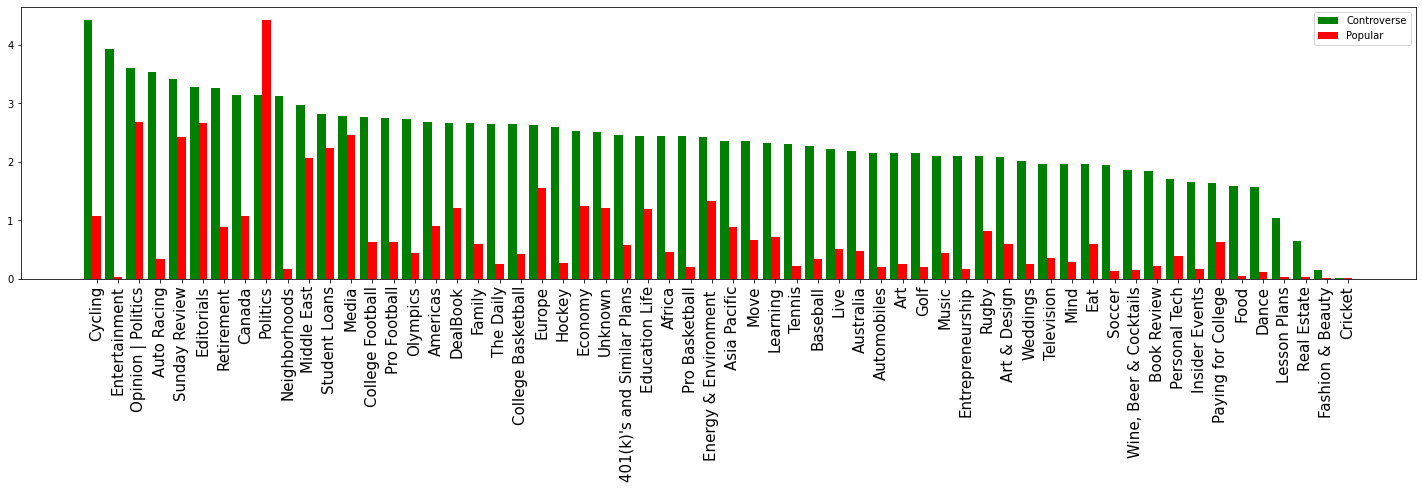

In [48]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.sectionName)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

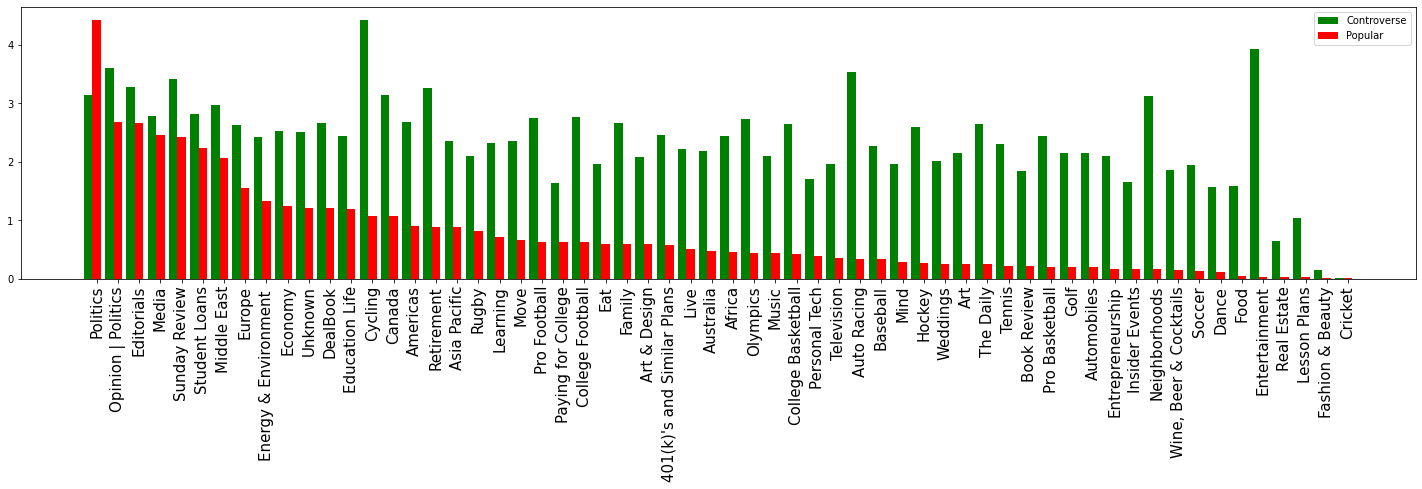

In [49]:
dftot.sort_values(by='Popularity',ascending=False,inplace=True)
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.sectionName)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

### Grouping by NewDesk - Strategy 1

In [50]:
dftot = pd.DataFrame()
dftot['newDesk'] = arts['newDesk'].unique()
dftot.sort_values(by='newDesk',inplace=True)
grouper = arts.groupby('newDesk').mean()['controv']
grouper2 = arts.groupby('newDesk').mean()['commentNumber']
dftot['SecControv'] = dftot['newDesk'].map(grouper)
dftot['Popularity']= dftot['newDesk'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

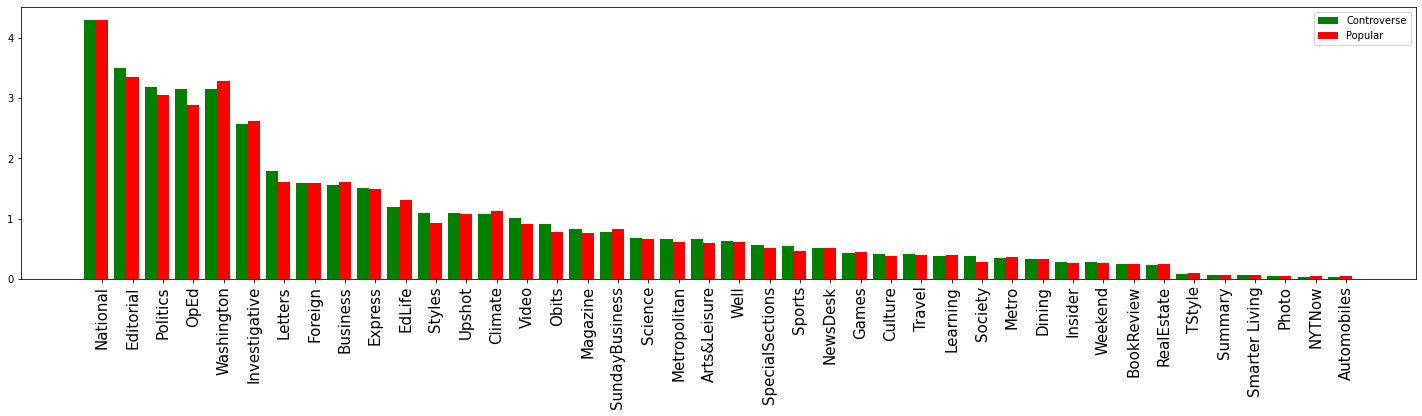

In [51]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.newDesk)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

### Strategy 2

In [52]:
dftot = pd.DataFrame()
dftot['newDesk'] = arts2['newDesk'].unique()
dftot.sort_values(by='newDesk',inplace=True)
grouper = arts2.groupby('newDesk').mean()['controv']
grouper2 = arts2.groupby('newDesk').mean()['commentNumber']
dftot['SecControv'] = dftot['newDesk'].map(grouper)
dftot['Popularity']= dftot['newDesk'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

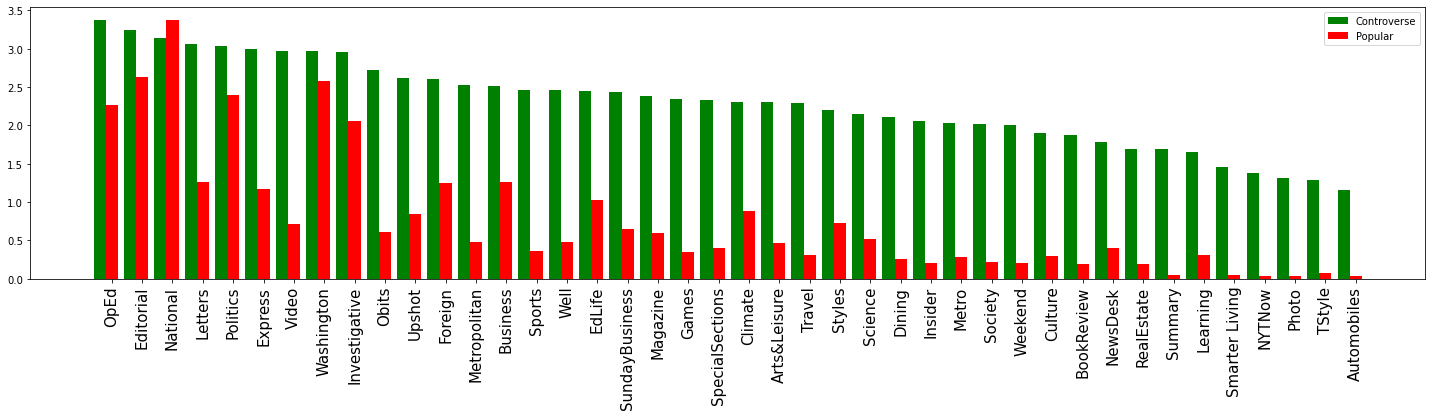

In [53]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Popular')

ax.set(xticks=ind + wi, xticklabels=dftot.newDesk)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

#### Grouping by AUTHOR - Strategy 2

In [54]:
# I have to select only authors with 20+ articles

In [55]:
dftot = pd.DataFrame()
dftot['byline'] = arts2['byline'].unique()
grp = arts2.groupby('byline')['newDesk'].count()
dftot['artNum'] = dftot['byline'].map(grp)
#grouper = arts2.groupby('byline').count()
#grouper
dftot.sort_values(by='artNum',ascending=False, inplace=True)
dftot = dftot[ dftot['artNum']> 30 ]

In [56]:
dftot.sort_values(by='byline',inplace=True)
grouper = arts2.groupby('byline').mean()['controv']
grouper2 = arts2.groupby('byline').mean()['commentNumber']
dftot['SecControv'] = dftot['byline'].map(grouper)
dftot['Popularity']= dftot['byline'].map(grouper2)
dftot['Popularity'] = dftot['Popularity'] * dftot['SecControv'].max() / dftot['Popularity'].max()
dftot.sort_values(by='SecControv',ascending=False,inplace=True)

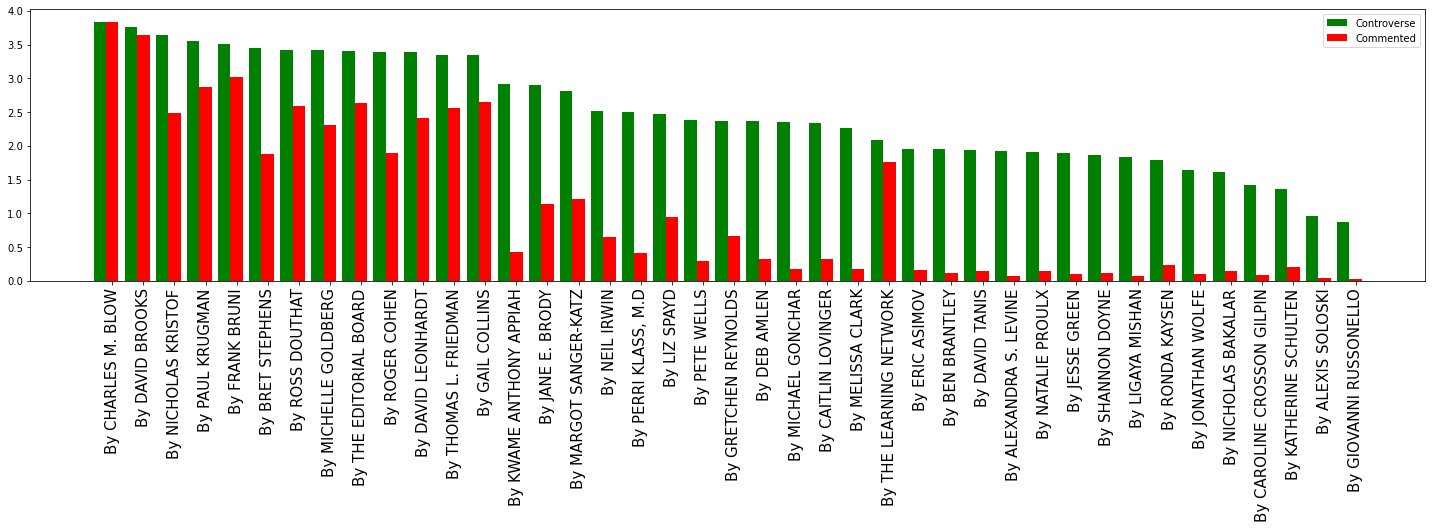

In [57]:
fig, ax = plt.subplots(figsize=(25,5))
ind = np.arange(len(dftot))
wi = 0.4
ax.bar(ind, dftot.SecControv, wi, color='green', label='Controverse')
ax.bar(ind + wi, dftot.Popularity, wi, color='red', label='Commented')

ax.set(xticks=ind + wi, xticklabels=dftot.byline)
plt.xticks(fontsize=15, rotation=90)
ax.legend()
plt.show()

### TF-IDF to extract 'controversial words'

In [58]:
# I need to keep only most controversial comments
# that is, all comments related to most controversial articles
# (sort of reverse groupby)

In [59]:
dfcon = pd.DataFrame()
arts2.sort_values(by='controv',ascending=False)
f10p = int(len(arts2)/10)
dfcon = arts2.head(f10p)

In [60]:
topIDs = list (dfcon['articleID'])
comms_elite = comms [ comms['articleID'].isin (topIDs) ]
#comms_elite['commentScore'].hist(bins=100)
comms_elite['label'] = round(comms['commentScore'])

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
vect = TfidfVectorizer()

corpus2 = [w for w in comms_elite['commentBody']]

X = vect.fit_transform(corpus2)
print(X.shape)

ch2 = SelectKBest(chi2,k=150)
X_new = ch2.fit_transform(X, y=comms_elite['label'])

feature_names = [vect.get_feature_names()[i] for i in ch2.get_support(indices=True)]

print(feature_names, sep=' ')

(566742, 115082)
['againoh', 'againthank', 'againto', 'ahia', 'allamerica', 'ami', 'anger', 'assault', 'attack', 'autoworkerson', 'award', 'awayat', 'bad', 'ban', 'bednarik', 'best', 'bestpart', 'better', 'blame', 'bless', 'borderunmatch', 'brilliant', 'care', 'champagneth', 'childreni', 'choicethat', 'chuch', 'condem', 'corrupt', 'crime', 'culumn', 'danger', 'dangermi', 'dayno', 'dead', 'death', 'destroy', 'die', 'disgust', 'drugsw', 'einstien', 'enjoy', 'evil', 'fake', 'fan', 'fear', 'fire', 'flaga', 'fraud', 'fun', 'furthburn', 'futurea', 'gift', 'glad', 'good', 'great', 'gun', 'ha', 'hanh', 'harass', 'hate', 'health', 'hee', 'help', 'heritagelet', 'heroesgreat', 'ho', 'holdback', 'hope', 'ihat', 'ispeopl', 'joband', 'jobth', 'journeyi', 'joy', 'justicethi', 'kill', 'liar', 'lightjobless', 'like', 'lost', 'love', 'luck', 'lutey', 'midig', 'militarywho', 'murder', 'mv', 'nhat', 'nice', 'okayso', 'oldtim', 'omertà', 'payunsightli', 'pei', 'peopleth', 'perfect', 'pima', 'playal', 'poor

In [62]:
featurestring = ' '.join(word for word in feature_names)
real_features = afinn.find_all(featurestring)
print("Top " + str(len(real_features)) + " most controversial words:")
print()
for feat in real_features:
    print(feat, end='  ')

Top 78 most controversial words:

anger  assault  attack  award  bad  ban  best  better  blame  bless  brilliant  care  corrupt  crime  danger  dead  death  destroy  die  disgust  enjoy  evil  fake  fan  fear  fire  fraud  fun  gift  glad  good  great  gun  ha  harass  hate  help  hope  joy  kill  liar  like  lost  love  luck  murder  nice  perfect  prison  problem  punish  racism  racist  rape  rapist  shame  share  shoot  stupid  super  superb  support  terror  terrorist  thank  treason  true  victim  violent  war  warn  wealth  win  winner  worst  wow  wrong  xoxoxo  

In [63]:
arts_pre['sectionName'].value_counts()

Unknown          6380
Politics          638
Sunday Review     353
Television        261
Asia Pacific      174
                 ... 
Real Estate         1
Student Loans       1
Automobiles         1
Entertainment       1
Rugby               1
Name: sectionName, Length: 62, dtype: int64